## Chain in Langgraph

In this section we will build a simple chain using langgraph that uses 4 important concepts

- How to use chat message as a graph state

- How to use chat models in graph nodes

- How to bind tools to our LLM in chat models

- How to execute tool calls in graph nodes

In [1]:
from dotenv import load_dotenv
load_dotenv

import os
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

## 1. ChatMessages

In [2]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

messages = [AIMessage(content=f"Hello! How can I assist you today?" , name = "LLMModel")]
messages.append(HumanMessage(content="What's the weather like today?", name = "User"))
messages.append(AIMessage(content="The weather today is sunny with a high of 75°F.", name = "LLMModel"))
# In graph state this appending part is taken care by use of reducers


for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: LLMModel

Hello! How can I assist you today?
================================ Human Message =================================
Name: User

What's the weather like today?
================================== Ai Message ==================================
Name: LLMModel

The weather today is sunny with a high of 75°F.


## 2. Chat Models

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
result = llm.invoke(messages)

/Users/shivangsingh/Desktop/Shivang/Shivang_Codes/Agentic-AI-BootCamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 1,
  'prompt_tokens': 69,
  'total_tokens': 70,
  'completion_time': 0.007000217,
  'prompt_time': 0.00249089,
  'queue_time': None,
  'total_time': 0.009491107},
 'model_name': 'llama-3.3-70b-versatile',
 'system_fingerprint': 'fp_c06d5113ec',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None,
 'model_provider': 'groq'}

## 3. Tools

- They are simple functions/external API's that the LLM can call

- They enable LLM's to take action instead of just generating text.

- Examples:
    - search the web
    - write to a DB
    - do calculations
    - call APIs
    - run Python code
    - fetch embeddings

In [5]:
def add(a:int, b:int)-> int:
    """
    Add a and b
    Args:
        a(int) : first_int
        b(int) : second_int

    Returns:
        int
    """
    return a+b

In [6]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x119ddbec0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x119eec230>, model_name='llama-3.3-70b-versatile', temperature=1e-08, model_kwargs={}, groq_api_key=SecretStr('**********'))

In [7]:
#Lets bind our "add()" tool to our  llm
llm_with_tools = llm.bind_tools([add])

tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2+2", name="Krish")])

In [8]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'mgv2y5gaw',
  'type': 'tool_call'}]

### Using messages with state

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

## 4. Routers

- They are special type of nodes, whose job is to look at current state, choose one of many possible next nodes and route the execution there

- This allows LangGraph to behave like:

    - decision trees

    - conditional workflows

    - multi-agent orchestration

    - branch logic

    - state-based control flow

- So basically graphs introduce "intelligence" or "logic branching" into our workflows

- There are 2 ways to create a router

    1) Logic based - Python function where you hardcode  the route.

    2) LLM Based - Let the model decide which route to take.

In [10]:
from langgraph.graph.message import add_messages
from typing import Annotated
class State(TypedDict):
    message:Annotated[list[AnyMessage], add_messages]

### Reducers with add_messages

In [12]:
## add_message is a reducer

initial_messages = [AIMessage(content=f"Please tell me how I can help", name= "LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding", name= "Krish"))

initial_messages

[AIMessage(content='Please tell me how I can help', additional_kwargs={}, response_metadata={}, name='LLMModel')]

In [13]:
ai_message = AIMessage(content=f"Which programming language you want to learn", name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [14]:
## Reducers add_message is to append instead of override
add_messages(initial_messages, ai_message)

[AIMessage(content='Please tell me how I can help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='0f4a1144-a8a1-432a-81f1-619ce748faff'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='dd421fcf-b9a5-4015-a2a1-aa69188070d6')]

In [15]:
def llm_tool(state:State):
    return {messages : [llm_with_tools.invoke(state["message"])]}

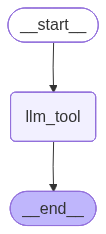

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

builder=StateGraph(State)

builder.add_node("llm_tool", llm_tool)

builder.add_edge(START, "llm_tool")
builder.add_edge("llm_tool", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
## Invocation
from pprint import pprint
messages = graph.invoke({"message" : "What is 2 plus 2?"})

for message in message:
    message.pretty_print()

TypeError: unhashable type: 'list'

### Implementing Tool Node

In [18]:
from langgraph.prebuilt import ToolNode
# tools_condition is used to decide at runtime whether you want to call a tool or not
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)

builder.add_node("llm_tool", llm_tool)
builder.add_node("tool", ToolNode(tools))

# Add Edge
builder.add_edge(START, "llm_tool")
builder.add_conditional_edges(
    "llm_tool",
    # If latest condition is from the chatbot which is the assistant is a tool call -> tools_condition routes to tools
    # If the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", END)

graph_builder = builder.compile()

NameError: name 'tools' is not defined

In [ ]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))